# Image generation



In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics

from vgg16_avg import VGG16_Avg

Using TensorFlow backend.
/home/paperspace/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Tell Tensorflow to use no more GPU RAM than necessary
limit_mem()

In [3]:
path = 'imagenet-sample-train/'
dpath = '/home/paperspace/New_folder-Copy/'

## Neural style transfer

### Setup

Our first step is to list out the files we have, and then grab some image.

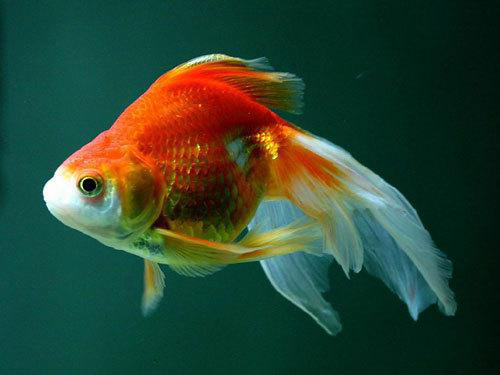

In [4]:
img=Image.open(dpath+'fish.jpg'); img

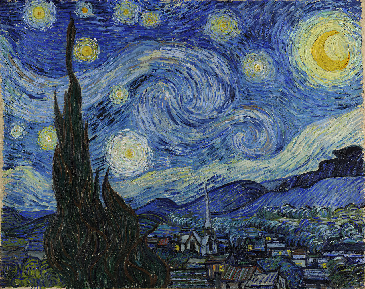

In [5]:
style = Image.open(dpath+'starry_night.jpg')
style = style.resize(np.divide(style.size,3.5).astype('int32')); style

That's a nice looking image! Feel free to use any other image that you're interested in playing with.

We'll be using this image with VGG16. Therefore, we need to subtract the mean of each channel of the imagenet data and reverse the order of RGB->BGR since those are the preprocessing steps that the VGG authors did - so their model won't work unless we do the same thing.

We can do this in one step using *broadcasting*, which is a topic we'll be returning to many times during this course.

In [6]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

When we generate images from this network, we'll need to undo the above preprocessing in order to view them.

In [7]:
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [8]:
img_arr = preproc(np.expand_dims(np.array(img), 0))
shp = img_arr.shape

### Recreate input

The first step in style transfer is understanding how to recreate an image from noise based on "content loss", which is the amount of difference between activations in some layer. In earlier layers, content loss is very similar to per-pixel loss, but in later layers it is capturing the "meaning" of a part of an image, rather than the specific details.

To do this, we first take a CNN and pass an image through it. We then pass a "noise image" (i.e. random pixel values) through the same CNN. At some layer, we compare the outputs from it for both images. We then use a MSE to compare the activations of these two outputs. 

The interesting part is that now, instead of updating the parameters of the CNN, we update the pixels of the noisy image. In other words, our goal is to alter the noisy image so as to minimize the difference between the original image's output at some convolutional layer with the output of the noisy image at the same layer.

In order to construct this architecture, we're going to be working with keras.backend, which is an abstraction layer that allows us to target both theano and tensorflow with the same code.

The CNN we'll use is VGG16, but with a twist. Previously we've always used Vgg with max pooling, and this was useful for image classification. It's not as useful in this case however, because max pooling loses information about the original input area. Instead we will use average pooling, as this does not throw away as much information.

In [9]:
model = VGG16_Avg(include_top=False)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, None, None, 64 1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, None, None, 64 36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (AveragePooling2D)   (None, None, None, 64 0           block1_conv2[0][0]               
___________________________________________________________________________________________

Here we're grabbing the activations from near the end of the convolutional model).

In [10]:
layer = model.get_layer('block5_conv1').output

And let's calculate the target activations for this layer:

In [11]:
layer_model = Model(model.input, layer)
targ = K.variable(layer_model.predict(img_arr))

In our implementation, we need to define an object that will allow us to separately access the loss function and gradients of a function, since that is what scikit-learn's optimizers require.

In [12]:
class Evaluator(object):
    def __init__(self, f, shp): self.f, self.shp = f, shp
        
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)

    def grads(self, x): return self.grad_values.flatten().astype(np.float64)

We'll define our loss function to calculate the mean squared error between the two outputs at the specified convolutional layer.

In [13]:
loss = metrics.mse(layer, targ)
grads = K.gradients(loss, model.input)
fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(fn, shp)

Now we're going to optimize this loss function with a deterministic approach to optimization that uses a line search, which we can implement with sklearn's `fmin_l_bfgs_b` funtionc. 

In [14]:
def solve_image(eval_obj, niter, x):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
        scipy.misc.imsave(dpath+'/results/content/res_at_iteration_'+str(i)+'.png', deproc(x.copy(), shp)[0])
    return x

Next we need to generate a random image.

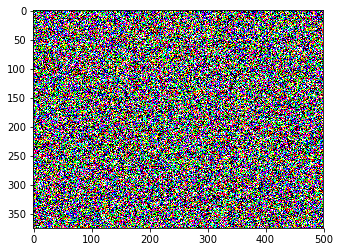

In [15]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
x = rand_img(shp)
plt.imshow(x[0]);

Now we'll run through this optimization approach ten times and train the noise image's pixels as desired.

In [16]:
iterations=10

In [17]:
x = solve_image(evaluator, iterations, x)

Current loss value: 63.9044303894
Current loss value: 21.0394134521
Current loss value: 13.0269193649
Current loss value: 9.40900611877
Current loss value: 7.54735994339
Current loss value: 6.22263813019
Current loss value: 5.41138505936
Current loss value: 4.69321966171
Current loss value: 4.19841623306
Current loss value: 3.85784387589


Our result by comparing output at conv 1 of last block (5) is fairly amorphous, but still easily recognizable as a bird. Notice that the things it has reconstructed particularly well are those things that we expect Vgg16 to be good at recognizing, such as an eye or a beak.

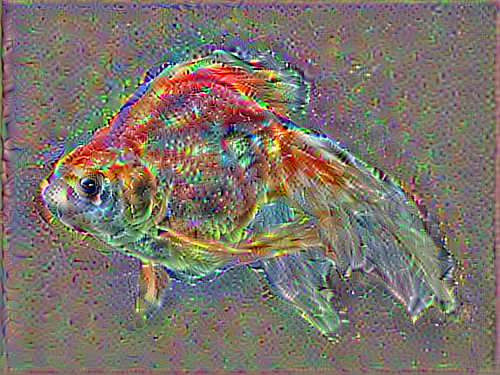

In [18]:
Image.open(dpath+'results/content/res_at_iteration_9.png')

### Recreate style

Now that we've learned how to recreate an input image, we'll move onto attempting to recreate *style*. By "style", we mean the color palette and texture of an image. Unlike recreating based on content, with style we are not concerned about the actual structure of what we're creating, all we care about is that it captures this concept of "style".

Here are some examples of images we can extract style from.

In [19]:
def plot_arr(arr): plt.imshow(deproc(arr,arr.shape)[0].astype('uint8'))

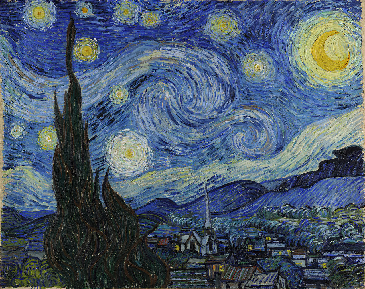

In [20]:
style = Image.open('starry_night.jpg')
style = style.resize(np.divide(style.size,3.5).astype('int32')); style

We're going to repeat the same approach as before, but with some differences.

In [21]:
style_arr = preproc(np.expand_dims(style,0)[:,:,:,:3])
shp = style_arr.shape

In [22]:
model = VGG16_Avg(include_top=False, input_shape=shp[1:])
outputs = {l.name: l.output for l in model.layers}

One thing to notice is that we're actually going to be calculating the loss function multiple layers, rather than just one. (Note however that there's no reason you couldn't try using multiple layers in your content loss function, if you wanted to try that).

In [23]:
#layers = [outputs['block{}_conv1'.format(o)] for o in range(1,3)]
layers = model.get_layer('block2_conv1').output

In [24]:
layers_model = Model(model.input, layers)
#targs = [K.variable(o) for o in layers_model.predict(style_arr)]
targs = K.variable(layers_model.predict(style_arr))

The key difference is our choice of loss function. Whereas before we were calculating mse of the raw convolutional outputs, here we transform them into the "gramian matrix" of their channels (that is, the product of a matrix and its transpose) before taking their mse. It's unclear why this helps us achieve our goal, but it works. One thought is that the gramian  shows how our features at that convolutional layer correlate, and completely removes all location information. So matching the gram matrix of channels can only match some type of texture information, not location information.

In [25]:
def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

In [26]:
def style_loss(x, targ): return metrics.mse(gram_matrix(x), gram_matrix(targ))

In [27]:
#loss = sum(style_loss(l1[0], l2[0]) for l1,l2 in zip(layers, targs))
loss = style_loss(layers[0], targs[0])
grads = K.gradients(loss, model.input)
style_fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(style_fn, shp)

We then solve as we did before.

In [28]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/1
x = rand_img(shp)
x = scipy.ndimage.filters.gaussian_filter(x, [0,2,2,0])

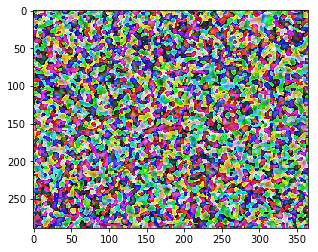

In [29]:
plt.imshow(x[0]);

In [30]:
def solve_image(eval_obj, niter, x):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
        scipy.misc.imsave(dpath+'/results/style/res_at_iteration_'+str(i)+'.png', deproc(x.copy(), shp)[0])
    return x

In [31]:
iterations=10
x = rand_img(shp)

In [33]:
x = solve_image(evaluator, iterations, x)

Current loss value: 5.22929954529
Current loss value: 4.28117036819
Current loss value: 3.64678955078
Current loss value: 3.12735843658
Current loss value: 2.70246291161
Current loss value: 2.39341521263
Current loss value: 2.11412787437
Current loss value: 1.7984534502
Current loss value: 1.60774362087
Current loss value: 1.43770086765


Our results are stunning. By transforming the convolutional outputs to the gramian, we are somehow able to update the noise pixels to produce an image that captures the raw style of the original image, with absolutely no structure or meaning.

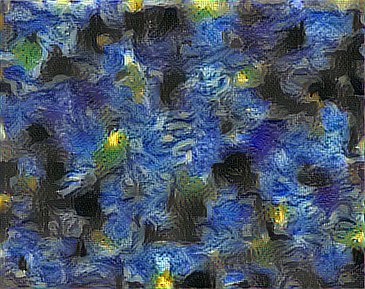

In [34]:
Image.open(dpath + 'results/style/res_at_iteration_9.png')

In [ ]:
Image.open(path + 'res_at_iteration_9.png')

### Style transfer

We now know how to reconstruct an image, as well as how to construct an image that captures the style of an original image. The obvious idea may be to just combine these two approaches by weighting and adding the two loss functions.

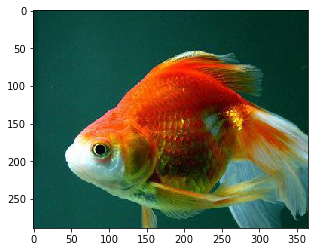

In [35]:
w,h = style.size
src = img_arr[:,:h,:w]
plot_arr(src)

Like before, we're going to grab a sequence of layer outputs to compute the style loss. However, we still only need one layer output to compute the content loss. How do we know which layer to grab? As we discussed earlier, the lower the layer, the more exact the content reconstruction will be. In merging content reconstruction with style, we might expect that a looser reconstruction of the content will allow more room for the style to have an effect (re: inspiration). Furthermore, a later layer ensures that the image "looks like" the same subject, even if it doesn't have the same details.

In [137]:
style_layers = [outputs['block{}_conv2'.format(o)] for o in range(1,6)]
content_name = 'block4_conv2'
content_layer = outputs[content_name]
#style_layers = outputs['block2_conv1']

In [138]:
style_model = Model(model.input, style_layers)
style_targs = [K.variable(o) for o in style_model.predict(style_arr)]
#style_targs = K.variable(style_model.predict(style_arr))

In [139]:
content_model = Model(model.input, content_layer)
content_targ = K.variable(content_model.predict(src))

Now to actually merge the two approaches is as simple as merging their respective loss functions. Note that as opposed to our previous to functions, this function is producing three separate types of outputs: one for the original image, one for the image whose style we're emulating, and one for the random image whose pixel's we are training. 

One way for us to tune how the reconstructions mix is by changing the factor on the content loss, which we have here as 1/10. If we increase that denominator, the style will have a larger effect on the image, and if it's too large the original content of the image will be obscured by unstructured style. Likewise, if it is too small than the image will not have enough style.

In [140]:
style_wgts = [0.05,0.2,0.2,0.25,0.3]

In [141]:
loss = sum(style_loss(l1[0], l2[0])*w
           for l1,l2,w in zip(style_layers, style_targs, style_wgts))
#loss = style_loss(style_layers[0], style_targs[0])
loss += metrics.mse(content_layer, content_targ)/10
grads = K.gradients(loss, model.input)
transfer_fn = K.function([model.input], [loss]+grads)

In [142]:
def solve_image(eval_obj, niter, x):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
        scipy.misc.imsave(dpath+'/results/StyleContent/res_at_iteration_'+str(i)+'.png', deproc(x.copy(), shp)[0])
    return x

In [143]:
evaluator = Evaluator(transfer_fn, shp)

In [144]:
iterations=10
x = rand_img(shp)

In [145]:
x = solve_image(evaluator, iterations, x)

Current loss value: 2803.57324219
Current loss value: 815.077880859
Current loss value: 477.984069824
Current loss value: 386.071929932
Current loss value: 339.573425293
Current loss value: 309.027770996
Current loss value: 284.127960205
Current loss value: 266.358642578
Current loss value: 247.697860718
Current loss value: 234.995620728


These results are remarkable. Each does a fantastic job at recreating the original image in the style of the artist.

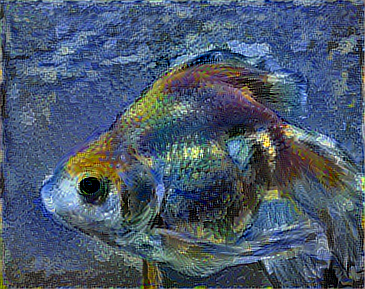

In [146]:
Image.open(dpath + 'results/StyleContent/res_at_iteration_9.png')

There are lots of interesting additional things you could try, such as the ideas shown here: https://github.com/titu1994/Neural-Style-Transfer .